# HM1 algorithms and hyperparameters tuning

### KNN algorithm

# Data

44 spam

1067 nasa https://www.openml.org/search?type=data&status=active&id=1067

1464 blood-transfusion-service-center

40701 churn

### Libraries

In [171]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import openml
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Data input

In [172]:
dataset = {}
data = {}
labels = {}
id = [44,1067,1464,40701]
for index in id:
    dataset[index] = openml.datasets.get_dataset(index)
    data[index], y, _, _ = dataset[index].get_data(dataset_format="dataframe")
    data[index] = data[index].replace('nan', np.nan) # not always needed
    labels[index] = list(data[index].columns.values)

c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Prog

### Preprocessing

In [173]:
def preprocess():
    num_pipeline = Pipeline(steps=[
        ('scale',MinMaxScaler())
    ])

    ### operacje dla kolumn kategorycznych
    cat_pipeline = Pipeline(steps=[
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))

    ])

    col_trans = ColumnTransformer(transformers=[
        ('num_pipeline', num_pipeline, make_column_selector( dtype_exclude= np.object_)),
        ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_)),
        ],
    
        n_jobs=-1)
    
    model = Pipeline([('preprocessing', col_trans)])
    return model

In [174]:
data_prepared = {}
for index in id:
    datad = data[index]
    model =  preprocess()
    model.get_params()
    model.fit(datad)
    after_process = model.transform(datad)
    data_prepared[index] = pd.DataFrame(after_process, columns = labels[index])

### Data split

In [175]:
yColumnName = {44:"class",1067:"defects",1464:"Class",40701:"class"}
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for index in id:

    X[index] = data_prepared[index].drop(yColumnName[index], axis=1)
    y[index] = data_prepared[index][yColumnName[index]]

    X_train[index],  X_test[index], y_train[index], y_test[index] = train_test_split(X[index], y[index])

## Grid search for tuning hyperparams

### RandomForestClassifier

In [176]:
pipeline = Pipeline([('KNeighborsClassifier', KNeighborsClassifier())])

In [177]:
pipeline.get_params()

{'memory': None,
 'steps': [('KNeighborsClassifier', KNeighborsClassifier())],
 'verbose': False,
 'KNeighborsClassifier': KNeighborsClassifier(),
 'KNeighborsClassifier__algorithm': 'auto',
 'KNeighborsClassifier__leaf_size': 30,
 'KNeighborsClassifier__metric': 'minkowski',
 'KNeighborsClassifier__metric_params': None,
 'KNeighborsClassifier__n_jobs': None,
 'KNeighborsClassifier__n_neighbors': 5,
 'KNeighborsClassifier__p': 2,
 'KNeighborsClassifier__weights': 'uniform'}

In [178]:
KNeighborsClassifier__n_neighbors = np.linspace(5, 100, 20).astype(np.int_)
KNeighborsClassifier__algorithm =  ['ball_tree', 'kd_tree', 'brute']

In [179]:
grid_params = [{'KNeighborsClassifier__n_neighbors':KNeighborsClassifier__n_neighbors,
                'KNeighborsClassifier__algorithm': KNeighborsClassifier__algorithm,
                }]

In [180]:
best_hyperparams = []
score_for_best_hyperparams = {}
std_scores = []
all_scores = {}

for index in id:
    gs_model_pipeline = RandomizedSearchCV(estimator=pipeline, param_distributions=grid_params,scoring='roc_auc',cv=2, n_iter=50, random_state=1)
    gs_model_pipeline.fit(X[index], y[index])
    best_hyperparams.append(gs_model_pipeline.best_params_)

    std_scores.append(gs_model_pipeline.cv_results_['mean_test_score'])
    all_scores[index] = gs_model_pipeline.cv_results_['mean_test_score']


# Plots for  RandomizedSearchCV()

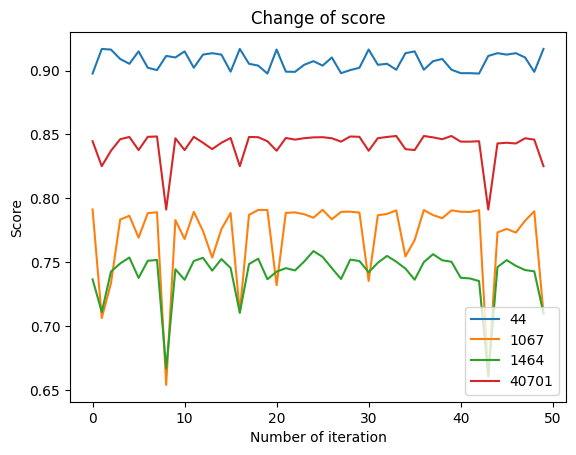

In [191]:
import matplotlib.pyplot as plt

for index in id:
    plt.plot(all_scores[index], label= index)
plt.title('Change of score')
plt.xlabel('Number of iteration')
plt.ylabel('Score')
plt.legend(loc='lower right')

In [213]:
def plot_r(index):
    Y_maxining = []
    max = 0
    for z in all_scores[index]: 
        if(z>max):
            max = z
        Y_maxining.append(max)

    plt.plot(Y_maxining)
    plt.plot( Y_maxining, 'o')
    plt.title('Change of score for dataset' )
    plt.xlabel('Number of iteration')
    plt.ylabel('Score')

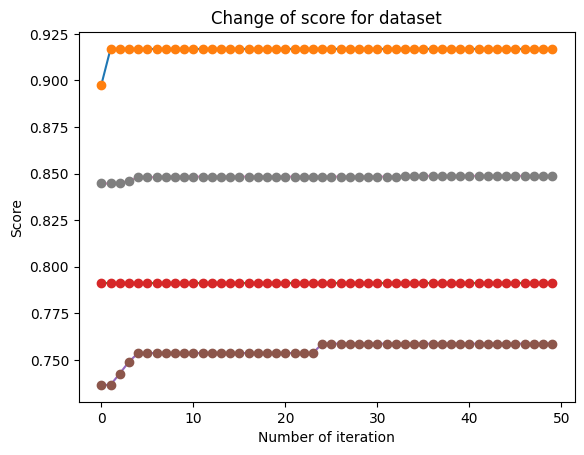

In [214]:
plot_r(44)
plot_r(1067)
plot_r(1464)
plot_r(40701)

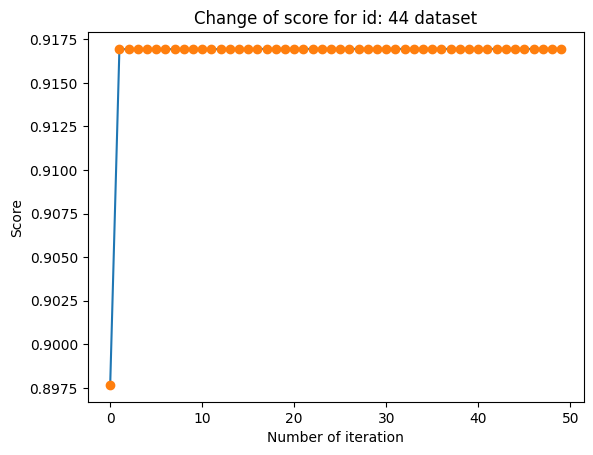

In [198]:
plot_r(44)

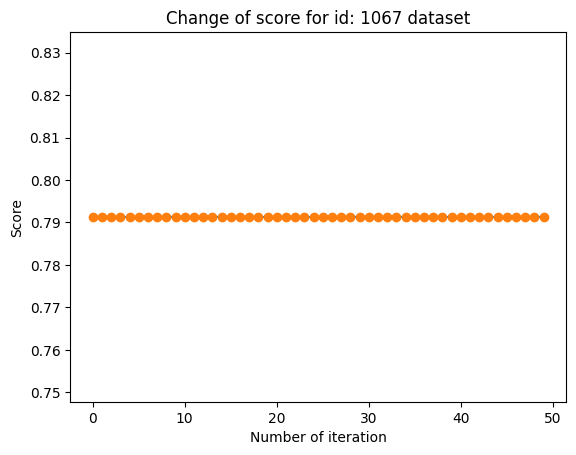

In [199]:
plot_r(1067)

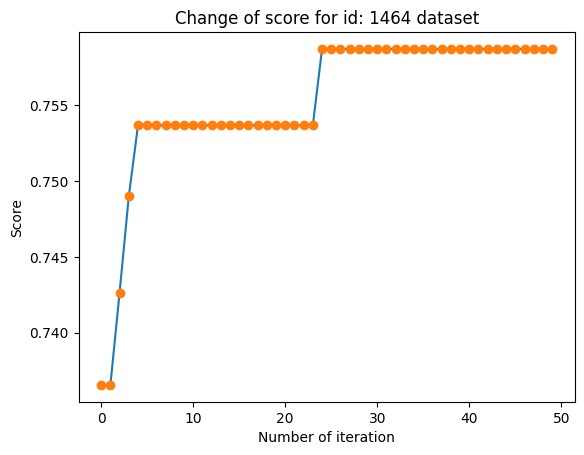

In [200]:
plot_r(1464)

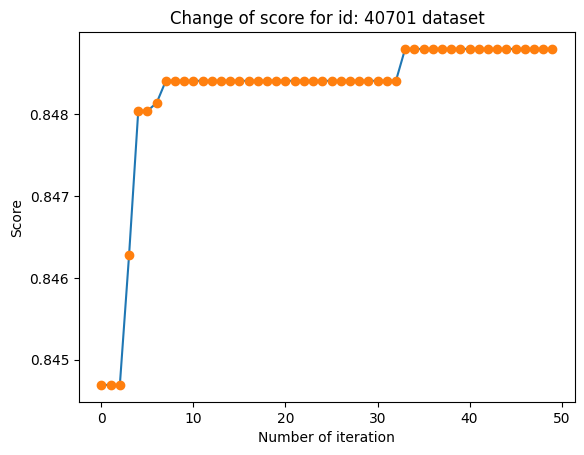

In [201]:
plot_r(40701)

# Default params

In [183]:
mean_std_vector   = np.mean(std_scores, axis =0)
minimum_std = np.max(mean_std_vector)
index_best = np.where(mean_std_vector == (minimum_std))[0][0]

In [184]:
for index in id:
    score_for_best_hyperparams[index] = np.max(all_scores[index])

In [186]:
defaults = gs_model_pipeline.cv_results_['params'][index_best]

### Diff for defaults - best

In [187]:
score_for_default_hyperparams = {}
diff = {}

for index in id:
    diff[index] = score_for_best_hyperparams[index] - all_scores[index][index_best]
diff

{44: 0.009577518810015784,
 1067: 0.0064579986500121755,
 1464: 0.0,
 40701: 0.0010879085229879015}

# Bayes Optimization

## BayesSearchCV

In [188]:
# number of iters to change
iters = 50

bayes_params = grid_params
best_hyperparams_bayes = []
all_scores_bayes = {}

for index in id:
    opt = BayesSearchCV(estimator=pipeline,search_spaces=bayes_params,scoring='roc_auc',cv=2, n_iter=iters)
    opt.fit(X[index], y[index])
    best_hyperparams_bayes.append(opt.best_params_)

    all_scores_bayes[index] = opt.cv_results_['mean_test_score']

c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:

# Plots for  BayesSearchCV()

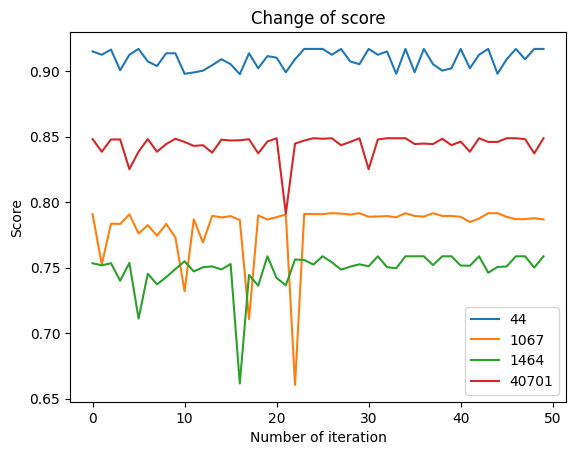

In [192]:
import matplotlib.pyplot as plt

for index in id:
    plt.plot(all_scores_bayes[index], label= index)
plt.title('Change of score')
plt.xlabel('Number of iteration')
plt.ylabel('Score')
plt.legend(loc='lower right')

In [211]:
def plot_(index):
    Y_maxining = []
    max = 0
    for z in all_scores_bayes[index]: 
        if(z>max):
            max = z
        Y_maxining.append(max)

    plt.plot(Y_maxining)
    plt.plot( Y_maxining, 'o')
    plt.title('Change of score for id: dataset' )
    plt.xlabel('Number of iteration')
    plt.ylabel('Score')

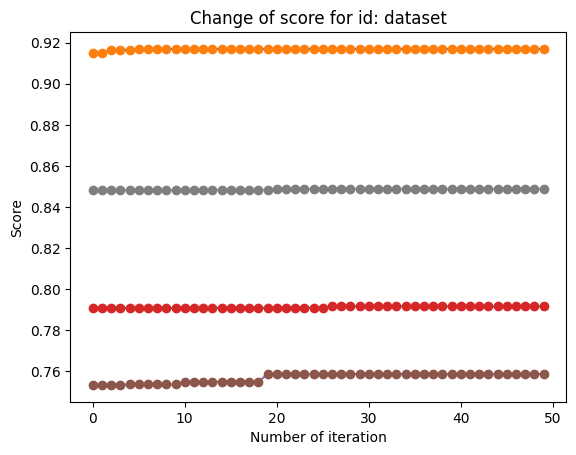

In [212]:
plot_(44)
plot_(1067)
plot_(1464)
plot_(40701)

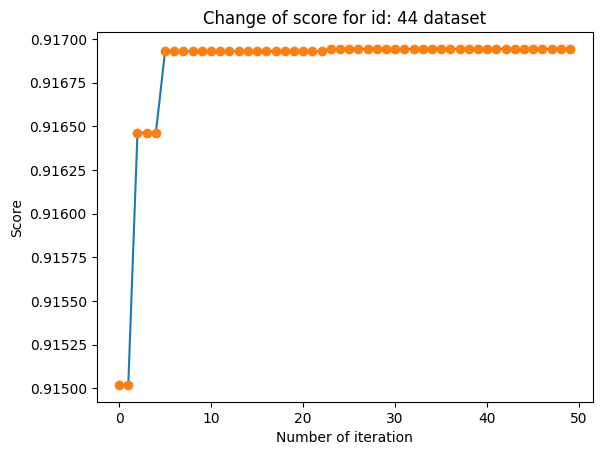

In [203]:
plot_(44)

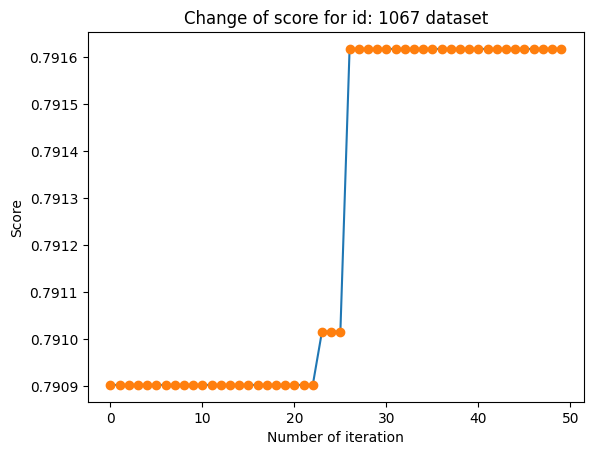

In [204]:
plot_(1067)

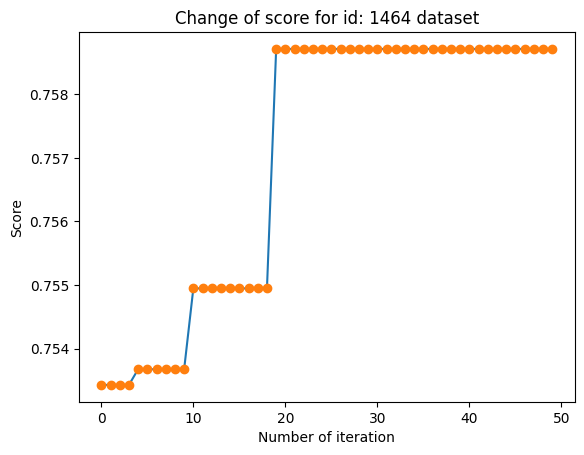

In [205]:
plot_(1464)

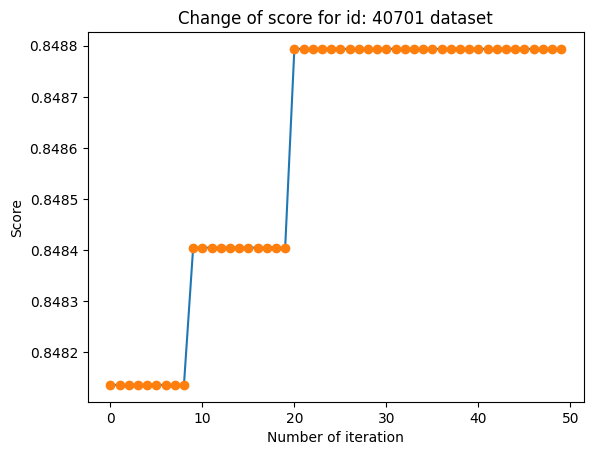

In [206]:
plot_(40701)

# Boxplots

Text(0.5, 1.0, 'Randomized Search -  KNN')

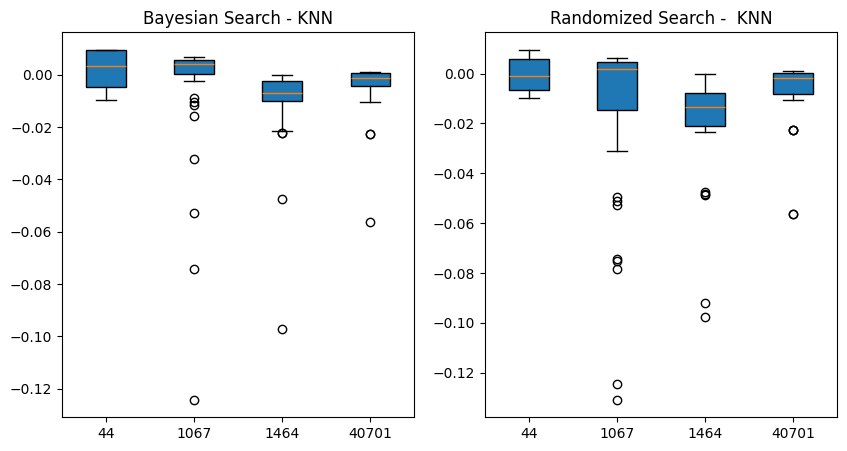

In [210]:
arrB = []
for index in id:
    arrB.append(all_scores_bayes[index] - all_scores[index][index_best])

arr = []
for index in id:
    arr.append(all_scores[index] - all_scores[index][index_best])


labels = id

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))


bplot1 = ax1.boxplot(arrB,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Bayesian Search - KNN')


bplot1 = ax2.boxplot(arr,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Randomized Search -  KNN')